#Importando bibliotecas

In [ ]:
import os
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
import torch
from skimage import io
import random
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torchvision.transforms import Compose, Normalize, ToTensor





#Conexao com o Kaggle

In [ ]:
from google.colab import files

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

In [ ]:
pip install kaggle -q

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%cd /content/
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

In [ ]:
!unzip chest-xray-pneumonia.zip -d XrayPneumonia

#Transformando os dados em csv

In [ ]:
import os
import csv

def criar_csv(diretorio_raiz, pasta):
    caminho_pasta = os.path.join(diretorio_raiz, pasta)
    dados = []

    for classe in os.listdir(caminho_pasta):
        caminho_classe = os.path.join(caminho_pasta, classe)
        if os.path.isdir(caminho_classe):  # Verifica se é um diretório
            for nome_arquivo in os.listdir(caminho_classe):
                if nome_arquivo != '.DS_Store':  # Ignora o arquivo .DS_Store
                    dados.append((nome_arquivo, classe))

    nome_arquivo_csv = f'dados_{pasta}.csv'

    with open(nome_arquivo_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['nome_da_imagem', 'Classe'])
        writer.writerows(dados)

    print(f'Arquivo CSV "{nome_arquivo_csv}" criado com sucesso!')

diretorio_raiz = '/content/XrayPneumonia/chest_xray/chest_xray'
pastas = ['train', 'test','val']

for pasta in pastas:
    criar_csv(diretorio_raiz, pasta)



#Transformando dados em dataframe

In [ ]:
Train_data = pd.read_csv('/content/dados_train.csv')
Test_data = pd.read_csv('/content/dados_test.csv')
Val_data = pd.read_csv('/content/dados_val.csv')

data = [Train_data,Test_data,Val_data]

issue = {'NORMAL':0, 'PNEUMONIA':1}

#substituindo para valor
for classes in data:
  classes['Classe'] = classes['Classe'].map(issue)

Train_data['nome_da_imagem']


#Testando a imagem
resultado = Train_data[Train_data['nome_da_imagem'] == 'person368_virus_748.jpeg']

print(resultado)

img = cv2.imread('/content/XrayPneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1799_bacteria_4647.jpeg')
plt.imshow(img)


#Configurando Dataloader para o pythorch



In [ ]:
import os
from PIL import Image


class XrayPneumonia(Dataset):
    def __init__(self, annotations_file_Dataframe, img_dirs, transform=None, target_transform=None):
        self.img_labels = annotations_file_Dataframe
        self.img_dirs = img_dirs  # Inicialmente, temos apenas um diretório
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, self.img_labels.iloc[idx, 0])
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")  # Forçar a conversão para RGB
                label = self.img_labels.iloc[idx, 1]
                if self.transform:
                    image = self.transform(image)
                if self.target_transform:
                    label = self.target_transform(label)
                return image, label




#Criando os dataloaders

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Definir o tamanho fixo para as imagens
fixed_size = (256, 256)  # Por exemplo, 224x224 pixels

# Definir transformações para redimensionar as imagens
transform = transforms.Compose([
    transforms.Resize(fixed_size),
    transforms.ToTensor()  # Converte a imagem para tensor
])

# Aplicar transformações aos conjuntos de dados
train_data = XrayPneumonia(Train_data, ['/content/XrayPneumonia/chest_xray/chest_xray/train/NORMAL','/content/XrayPneumonia/chest_xray/chest_xray/train/PNEUMONIA'], transform=transform)
test_data = XrayPneumonia(Test_data,  ['/content/XrayPneumonia/chest_xray/chest_xray/test/NORMAL','/content/XrayPneumonia/chest_xray/chest_xray/test/PNEUMONIA'], transform=transform)
val_data = XrayPneumonia(Val_data,  ['/content/XrayPneumonia/chest_xray/chest_xray/val/NORMAL','/content/XrayPneumonia/chest_xray/chest_xray/val/PNEUMONIA'], transform=transform)


# Criar os DataLoader com os conjuntos de dados transformados
dataloaders = {
    'train': DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2),
    'test': DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2)
}


# Tamanhos dos conjuntos de dados
dataset_sizes = {
    'train': len(train_data),
    'test': len(test_data)
}


#Congelando as camadas para transferlearning

In [ ]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Treinando a Rede

In [ ]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Testing the model with an unsee image

In [ ]:
# Save the model
torch.save(model.state_dict(), 'IdentifyPneumonia.pth')

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('IdentifyPneumonia.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

In [ ]:
# Load and preprocess the unseen image
image_path = '/content/XrayPneumonia/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'  # Replace with the path to your image
image = Image.open(image_path).convert('L')
image = image.convert('RGB')
fixed_size = (256, 256)  # Por exemplo, 224x224 pixels

# Definir transformações para redimensionar as imagens
transform = transforms.Compose([
    transforms.Resize(fixed_size),
    transforms.ToTensor()  # Converte a imagem para tensor
])

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = [0, 1]  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

map = {
    0: 'NORMAL',
    1: 'PNEUMONIA'
}

print(f'The predicted class is: {map[predicted_class_name]}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {map[predicted_class_name]}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

#Confusion matrix

Funcao que recebe imagem e o modelo, e retorna a previsao


In [ ]:

def passa_pela_rede(image_path,model):
  image = Image.open(image_path).convert('L')
  image = image.convert('RGB')
  fixed_size = (256, 256)  # Por exemplo, 224x224 pixels

  # Definir transformações para redimensionar as imagens
  transform = transforms.Compose([
      transforms.Resize(fixed_size),
      transforms.ToTensor()  # Converte a imagem para tensor
  ])

  input_tensor = transform(image)
  input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    # Perform inference
  with torch.no_grad():
      output = model(input_batch)

  # Get the predicted class
  _, predicted_class = output.max(1)


  # Map the predicted class to the class name
  class_names = [0, 1]  # Make sure these class names match your training data
  predicted_class_name = class_names[predicted_class.item()]

  map = {
      0: 'NORMAL',
      1: 'PNEUMONIA'
  }

  return map[predicted_class_name]



Carregando o modelo pré treinado

In [ ]:
# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('IdentifyPneumonia.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

Criando as listas de previsoes e a verdadeira

In [ ]:
img_dirs = ['/content/XrayPneumonia/chest_xray/chest_xray/val/NORMAL','/content/XrayPneumonia/chest_xray/chest_xray/val/PNEUMONIA']


predict_list = [] #lista das previsoes
true_list = [] #lista das verdadeiras

for img_dir in img_dirs: #le cada diretorio
  for idx in range(len(Val_data)):
    img_path = os.path.join(img_dir, Val_data.iloc[idx, 0]) #cria o image_path

    if os.path.exists(img_path): #verifica se o img path existe

      true_list.append(Val_data.iloc[idx, 1]) # adicona o a classe verdadeira na true list
      predict = passa_pela_rede(img_path, model) #faz a previsao utilizando o modelo
      predict_list.append(predict) #adciona na lista de predicts





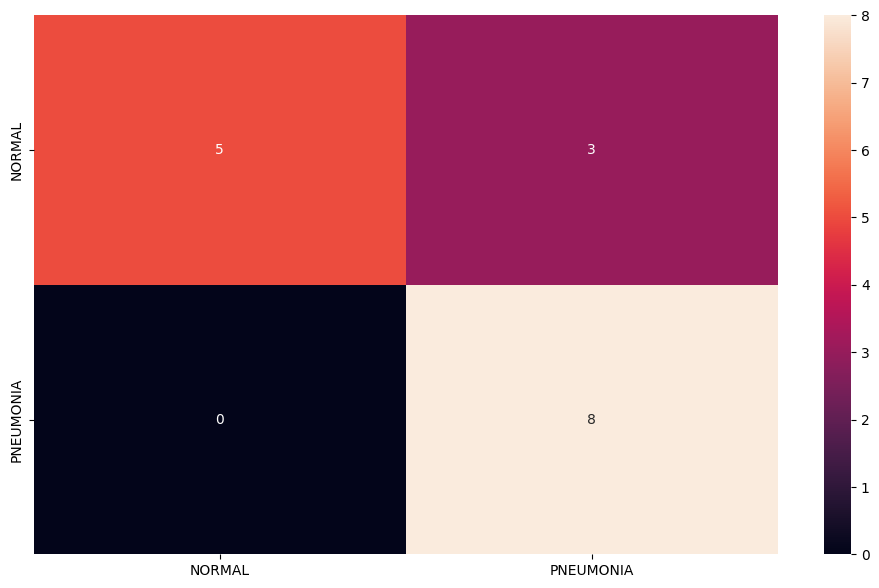

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

classes = ['NORMAL', 'PNEUMONIA']


cf_matrix = confusion_matrix(true_list, predict_list)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(true_list, predict_list)

0.8125

In [ ]:
print(classification_report(true_list, predict_list))

              precision    recall  f1-score   support

      NORMAL       1.00      0.62      0.77         8
   PNEUMONIA       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



#Conclusao

O modelo acerta de maneira interessante quando a imagem se trata de PNEUMONIA, logo quando é dado que é pneumonia há uma grande probabilidade de ser de fato PNEUMONIA. Porém quando é um pulmão nomal o modelo obteve apensa 0.62 de recall,logo um pulmão com pneumonia pode ser classificado como um pulmão normal




#Funcoes uteis

In [ ]:
def imprime_torchimg(image,label):
  image = image.permute(1, 2, 0)
  image = np.array(image)
  plt.imshow(image)
  plt.axis('off')
  plt.text(10, 10, f'Predicted: {label}', fontsize=12, color='white', backgroundcolor='red')
  plt.show()

y_pred = []
y_true = []

map = {
    0: 'NORMAL',
    1: 'PNEUMONIA'
}
